<a href="https://colab.research.google.com/github/kunalsonalkar/transformers-nlp/blob/main/Pytorch_Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Loading some data
from sklearn.datasets import make_circles

In [2]:
# making 1000 samples
n_samples = 1000
X, y = make_circles(n_samples, noise = 0.03, random_state=42)

In [3]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [4]:
y[:5]

array([1, 1, 1, 1, 0])

In [5]:
# making a dataframe out of circle dataset
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0], "X2":X[:,1], "label": y })
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [6]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Values for shape of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Values for shape of X: (2,) and the same for y: ()


In [9]:
# Turn data into tensors and create train-test split
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [11]:
# Build a model
  # Get standard pytorch imports
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
# Construct a model class which subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features=5)
    self.layer_2 = nn.Linear(in_features = 5, out_features=1)

  # Define a forward method containing forward pass computation
  def forward(self, X):
    return self.layer_2(self.layer_1(X)) # output of layer 1 goes through the layer 2 and produces output same as shape of y

# Create an instance of a model and send it to device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# model_0 will start off with random parameters
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.0906, -0.3367],
                      [-0.2740,  0.1207],
                      [-0.6898,  0.0923],
                      [-0.3695, -0.6896],
                      [-0.5418,  0.4555]])),
             ('layer_1.bias',
              tensor([ 0.4371,  0.2726, -0.3794, -0.1914,  0.2507])),
             ('layer_2.weight',
              tensor([[-0.3026,  0.2430,  0.2063,  0.3481,  0.2048]])),
             ('layer_2.bias', tensor([0.1003]))])

In [14]:
# we can try the same with nn.sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)

).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
# make predictions with the model - 1st pass
untrained_preds = model_0(X_test.to(device))

In [16]:
untrained_preds[:5]

tensor([[-0.3453],
        [-0.3142],
        [-0.2807],
        [-0.3642],
        [-0.0489]], grad_fn=<SliceBackward0>)

In [17]:
#Create a loss function and an optimizer
loss_function = nn.BCEWithLogitsLoss()
# loss function measures how incorrect is your model
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [18]:
# Evaluation measures how correct is your model
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [19]:
y_logits = model_0(X_test.to(device))[:5]

In [20]:
# logits are nothing but output of the forward pass
y_logits

tensor([[-0.3453],
        [-0.3142],
        [-0.2807],
        [-0.3642],
        [-0.0489]], grad_fn=<SliceBackward0>)

In [21]:
# sigmoid will make logits more consistent
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4145],
        [0.4221],
        [0.4303],
        [0.4100],
        [0.4878]], grad_fn=<SigmoidBackward0>)

In [22]:
# assign the predicted labels
y_preds = torch.round(y_pred_probs)
y_preds
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# torch.eq compares the equaity
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


In [24]:
# Build a training and testing loop
torch.manual_seed(42)

epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # 1. Forward pass (model outputs raw logits)
  y_logits = model_0(X_train).squeeze() # squeeze to remove extra dimension
  # 2. Turn logits to pred probability
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss

  # since our loss function is BCEWithLogitsLoss, we don't need to use sigmoid because its already in there.
  loss = loss_function(y_logits, y_train) # the BCEWithlogits loss function expects logits as an input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer Zero grad
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ## Testing loop
  model_0.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss/accuracy
    test_loss = loss_function(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

  if epoch%10==0:
    print(f"Epoch : {epoch} | Loss: {test_loss} | Test Accuracy: {test_acc} ")


Epoch : 0 | Loss: 0.6943247318267822 | Test Accuracy: 52.0 
Epoch : 10 | Loss: 0.6943063139915466 | Test Accuracy: 52.0 
Epoch : 20 | Loss: 0.6942939758300781 | Test Accuracy: 51.5 
Epoch : 30 | Loss: 0.6942866444587708 | Test Accuracy: 51.0 
Epoch : 40 | Loss: 0.694283664226532 | Test Accuracy: 51.0 
Epoch : 50 | Loss: 0.6942841410636902 | Test Accuracy: 50.0 
Epoch : 60 | Loss: 0.6942873597145081 | Test Accuracy: 49.0 
Epoch : 70 | Loss: 0.6942929029464722 | Test Accuracy: 49.5 
Epoch : 80 | Loss: 0.6943002939224243 | Test Accuracy: 49.5 
Epoch : 90 | Loss: 0.6943090558052063 | Test Accuracy: 48.0 


The component of non-linearity is missing. Recreate the non-linear data

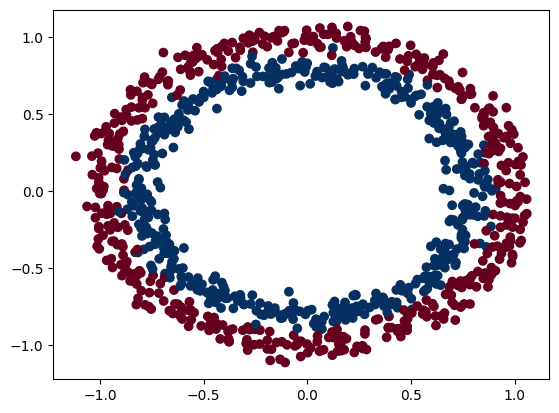

In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples = 1000

X, y = make_circles(n_samples=1000, noise =0.05, random_state=42)
plt.scatter(X[:,0], X[: ,1], c=y, cmap=plt.cm.RdBu)

In [28]:
# splitting into train and test
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[:5],y_train[:5]

(tensor([[ 0.6772, -0.4456],
         [ 0.6030, -0.7328],
         [-1.0219, -0.1066],
         [-0.9613, -0.2265],
         [-0.1646,  0.8112]]),
 tensor([1., 0., 0., 0., 1.]))

Building a model with non-linearity


In [29]:
from torch import nn
class CircleModelV1(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU() # add in ReLU, can also work with Sigmoid

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV1().to(device) # making the code device agnostic

In [30]:
print(model_3)

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [31]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1